## Imports

In [333]:
# Make the good imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

## Loading our DataFrame

In [334]:
#load the data
df = pd.read_csv('timeseries/blockchain_by_actor.csv', index_col=0, parse_dates=True)
df.tail()



,year,month,day,identity,received,nb_received,date,sum_fee,mean_fee_for100,nb_transactions,sent,self_spent,self_spent_estimated,nb_spent,spent
90398,0.0,0.0,0.0,BTCJam.com,0.0,0.0,2017-06-17,145053.0,8.643929,1.0,1387984.0,0.0,0.0,2.0,1387984.0
90399,0.0,0.0,0.0,7277,0.0,0.0,2017-06-18,26600900.0,49.327293,266.0,725280.0,0.0,0.0,532.0,725280.0
90400,0.0,0.0,0.0,70063369,0.0,0.0,2017-06-22,284134.0,0.301961,1.0,93527891.0,0.0,0.0,1.0,93527891.0
90401,0.0,0.0,0.0,Loanbase.com,0.0,0.0,2017-06-29,131862.0,1.415791,1.0,9049938.0,0.0,0.0,2.0,9049938.0
90402,0.0,0.0,0.0,7277,0.0,0.0,2017-06-29,39601350.0,49.327299,396.0,1079730.0,0.0,0.0,792.0,1079730.0


We notice that there is a problem with the year, month, day columns and on several data types in the raw DataFrame.
Let's clean it in order to work in good conditions.

## Cleaning our data

In [335]:
df.dtypes

year                    float64
month                   float64
day                     float64
identity                 object
received                float64
nb_received             float64
date                     object
sum_fee                 float64
mean_fee_for100         float64
nb_transactions         float64
sent                    float64
self_spent              float64
self_spent_estimated    float64
nb_spent                float64
spent                   float64
dtype: object

In [336]:
# convert year, month and day to int
df['year'] = df['year'].astype(int)
df['month'] = df['month'].astype(int)
df['day'] = df['day'].astype(int)

# convert the date to datetime in year-month-day format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# convert identity to string
df['identity'] = df['identity'].astype(str)

# convert nb_transactions, nb_received, nb_spent to int
df['nb_transactions'] = df['nb_transactions'].astype(int)
df['nb_received'] = df['nb_received'].astype(int)
df['nb_spent'] = df['nb_spent'].astype(int)


In [337]:
# get the year, month and day from the date
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

In [347]:
# save the df to a csv file
df.to_csv('timeseries/blockchain_by_actor_cleaned.csv')

In [338]:
# delete rows where spent is less than self_spent or less than self_spent_estimated
#df = df[df['spent'] >= df['self_spent']]
#df = df[df['spent'] >= df['self_spent_estimated']]



In [339]:
# sort the df by date
df = df.sort_values(by='date')
df

,year,month,day,identity,received,nb_received,date,sum_fee,mean_fee_for100,nb_transactions,sent,self_spent,self_spent_estimated,nb_spent,spent
0,2015,1,1,HappyCoins.com,1.377590e+09,4,2015-01-01,49596.0,0.004957,4,1.277500e+09,0.000000e+00,0.000000e+00,8,1.277500e+09
63,2015,1,1,269,7.323854e+08,190,2015-01-01,770000.0,0.260248,60,1.087653e+09,0.000000e+00,0.000000e+00,120,1.087653e+09
62,2015,1,1,Bter.com,4.232779e+10,338,2015-01-01,1070000.0,0.390202,70,7.314074e+10,1.921924e+10,1.921924e+10,148,5.392150e+10
61,2015,1,1,BitBargain.co.uk,4.153552e+09,25,2015-01-01,140000.0,0.095593,16,6.111821e+09,1.372861e+09,1.372861e+09,33,4.738960e+09
60,2015,1,1,72472408,4.213276e+08,6,2015-01-01,60000.0,0.027924,6,5.216480e+08,0.000000e+00,0.000000e+00,12,5.216480e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90301,2017,6,30,BTCJam.com,1.188544e+06,2,2017-06-30,145053.0,10.876816,1,1.043491e+06,0.000000e+00,0.000000e+00,2,1.043491e+06
90302,2017,6,30,417,1.269886e+11,935,2017-06-30,3197160.0,0.003197,2,1.000000e+11,0.000000e+00,1.000000e+11,2,0.000000e+00
90303,2017,6,30,CoinTrader.net_LocalBitcoins.com,5.399136e+10,665,2017-06-30,12474795.0,0.268176,9,4.164831e+10,3.001722e+09,3.001722e+09,58,3.864659e+10
90296,2017,6,30,ePay.info_CoinJoinMess,4.317324e+10,2438,2017-06-30,18664735.0,2.327340,277,1.449515e+11,1.205214e+11,1.205214e+11,4930,2.443010e+10


<Axes: title={'center': 'Evolution of the biggest spenders'}, xlabel='date'>

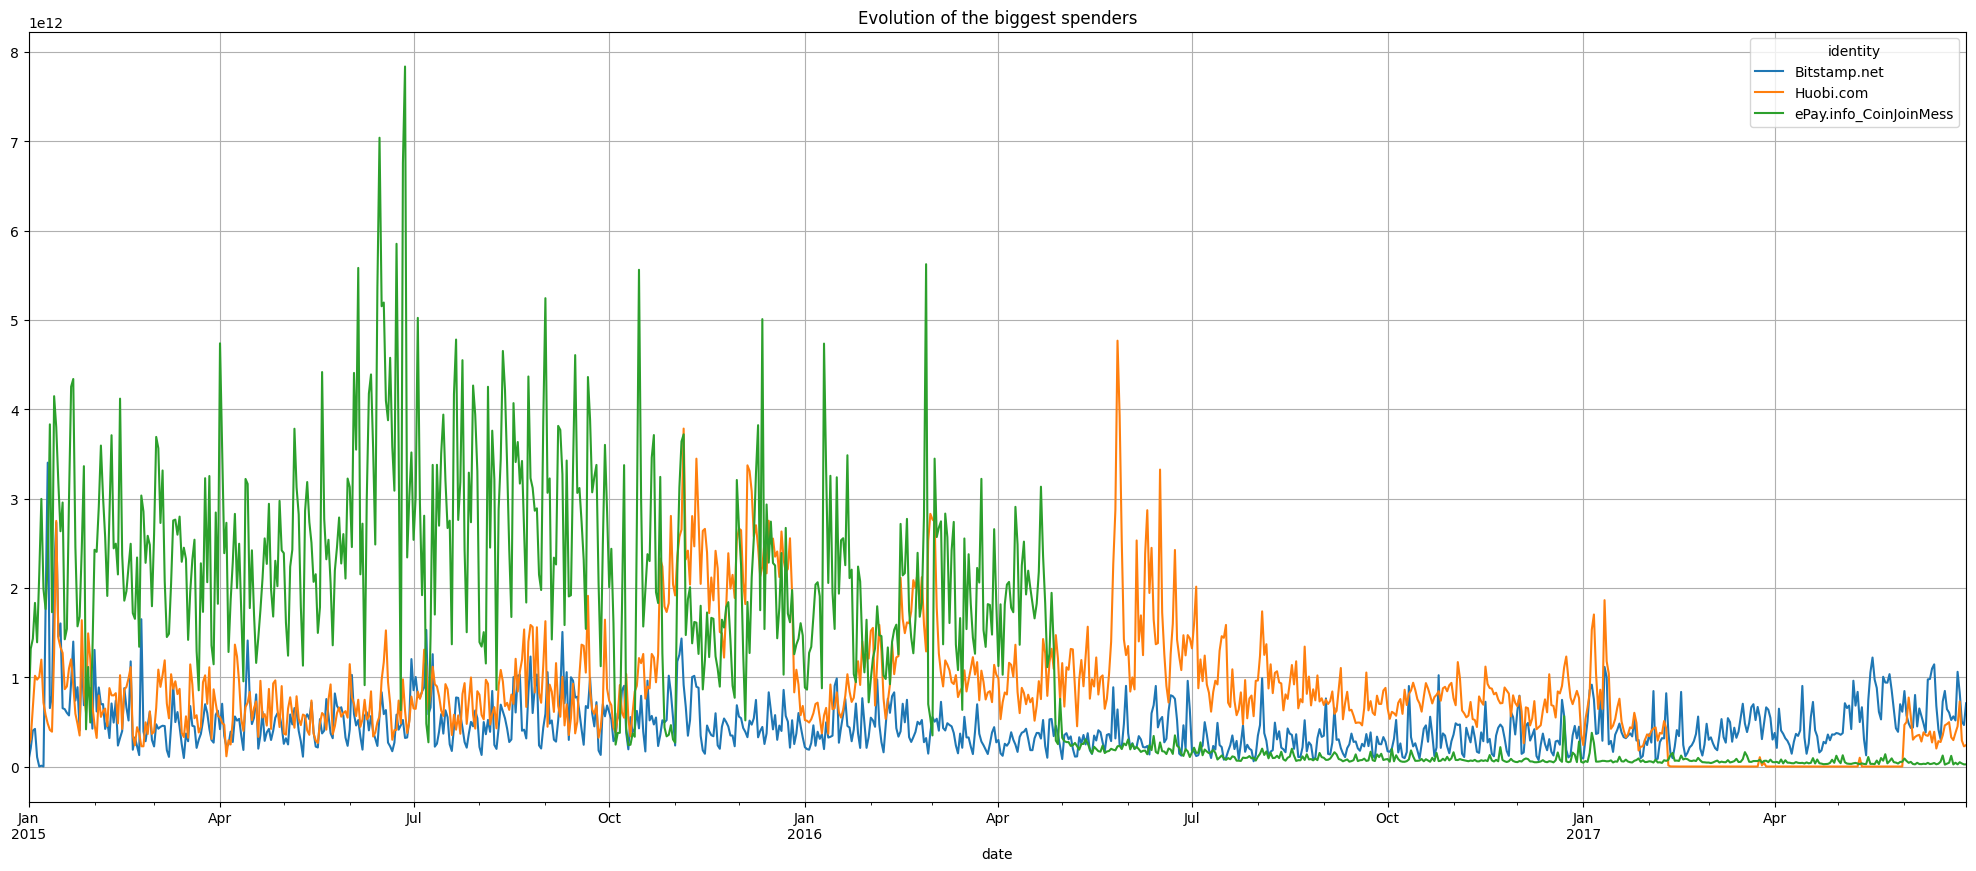

In [340]:
# get the names in a list of the 3 best identities in terms of spent column
best_spent = df.groupby('identity')['spent'].sum().sort_values(ascending=False).head(3).index.tolist()

# plot the evolution of best_sent in terms of spent column 
# date in x axis and spent in y axis
# with the title 'Evolution of the biggest spenders'
# with the label 'spent'
# with the legend
# with the grid
# with the figsize (15, 10)
df[df['identity'].isin(best_spent)].groupby(['date', 'identity'])['spent'].sum().unstack().plot(title='Evolution of the biggest spenders', label='spent', grid=True, figsize=(25, 10))




Now let's verify if they really are the biggest spenders...

We will define a new ranking by substracting the self_spent_estimated to the spent column

In [341]:
# create a new column 'real_spent' which is the spent column minus the self_spent_estimated column
df['real_spent'] = df['spent'] - (df['self_spent_estimated'] + df['self_spent'])

# if the real_spend is negative, replace it by 0
df['real_spent'] = df['real_spent'].apply(lambda x: 0 if x < 0 else x)






<Axes: title={'center': 'Evolution of the real biggest spenders'}, xlabel='date'>

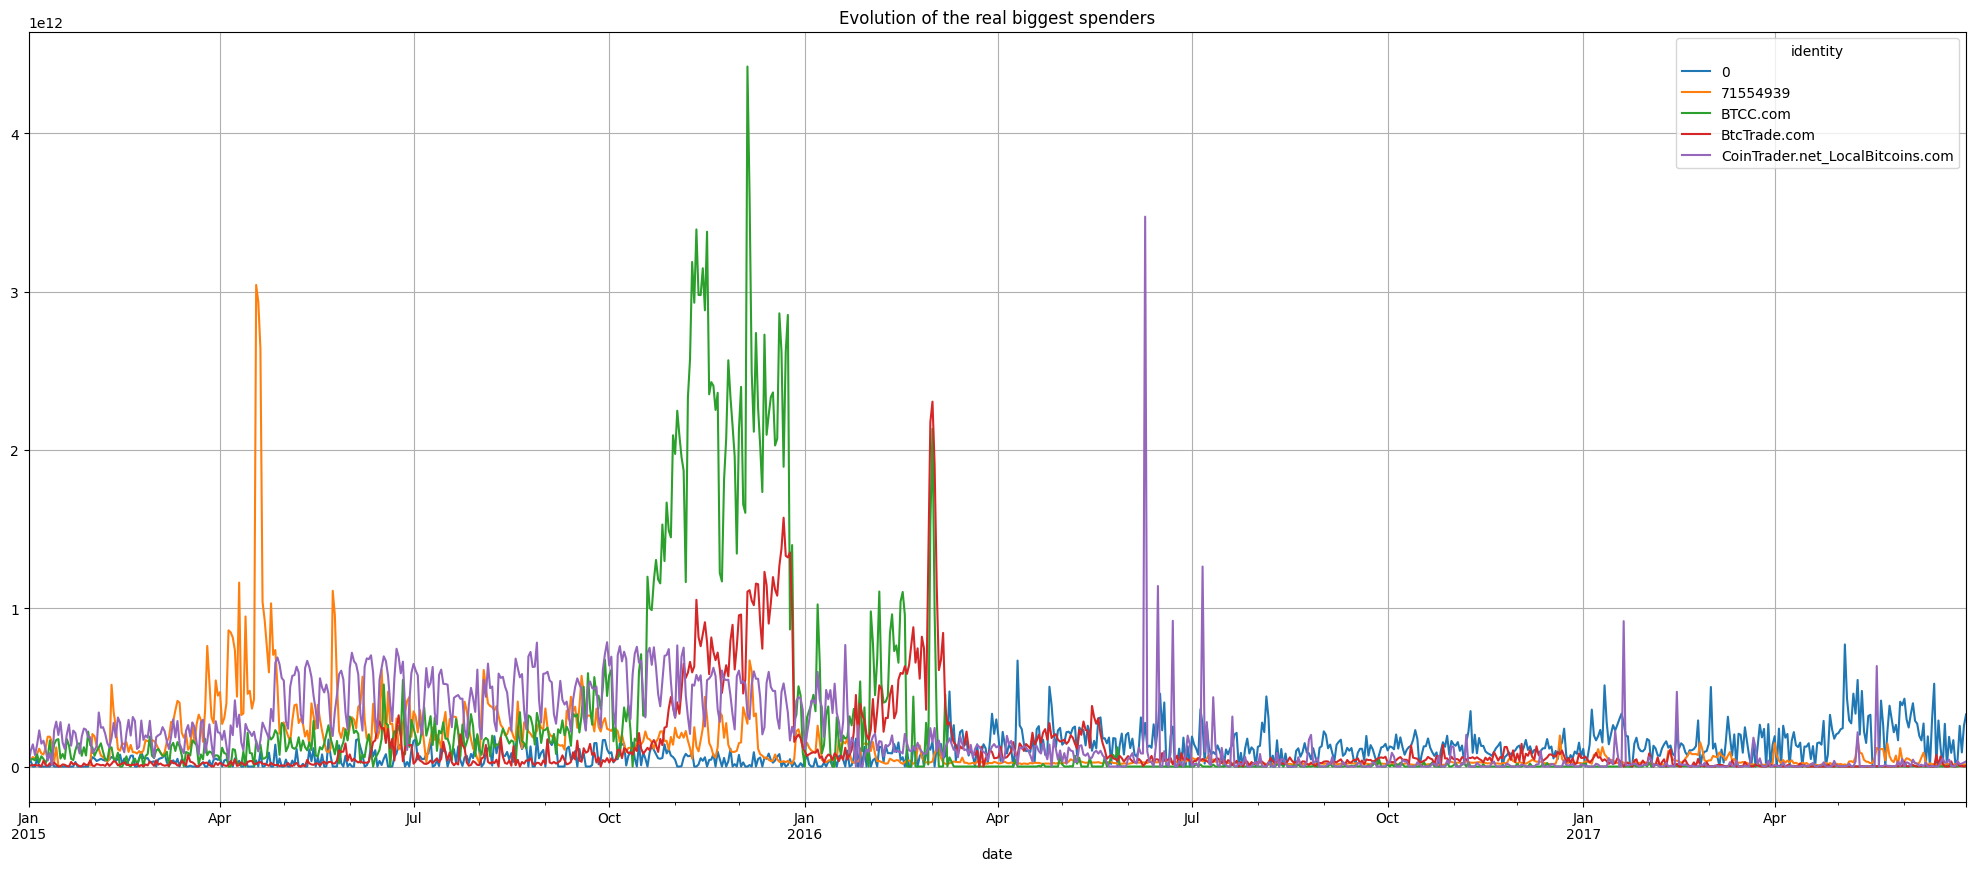

In [342]:
# now let's find the 5 best identities in terms of real_spent column
best_real_spent = df.groupby('identity')['real_spent'].sum().sort_values(ascending=False).head(5).index.tolist()

# plot the evolution of best_real_spent with real_spent column
# date in x axis and real_spent in y axis
df[df['identity'].isin(best_real_spent)].groupby(['date', 'identity'])['real_spent'].sum().unstack().plot(title='Evolution of the real biggest spenders', label='real_spent', grid=True, figsize=(25, 10))





In [344]:
# make a mean of the real_spent column by identity
# and sort the values by descending order
# and get the first 3 values

# get the names in a list of the 3 best identities in terms of real_spent column
top3_mean_spenders = df.groupby('identity')['real_spent'].mean().sort_values(ascending=False).head(3).index.tolist()
top3_mean_spenders



['BTCC.com', 'CoinTrader.net_LocalBitcoins.com', '71554939']

In [345]:
df.groupby('identity')['real_spent'].mean().sort_values(ascending=False)

identity
BTCC.com                            2.469712e+11
CoinTrader.net_LocalBitcoins.com    1.990819e+11
71554939                            1.276382e+11
BtcTrade.com                        1.274631e+11
0                                   1.018777e+11
                                        ...     
Bitbond.com                         3.781105e+07
SimpleCoin.cz                       2.482969e+07
BitZillions.com                     2.197085e+07
7277                                1.421262e+07
ePay.info_CoinJoinMess              0.000000e+00
Name: real_spent, Length: 100, dtype: float64

In [346]:
# display ePay.info_CoinJoinMess transaction
df[df['identity'] == 'ePay.info_CoinJoinMess']

,year,month,day,identity,received,nb_received,date,sum_fee,mean_fee_for100,nb_transactions,sent,self_spent,self_spent_estimated,nb_spent,spent,real_spent
22,2015,1,1,ePay.info_CoinJoinMess,5.482961e+11,12818,2015-01-01,38239914.0,0.524910,1148,2.470622e+12,1.794224e+12,1.898125e+12,20749,5.724979e+11,0.0
145,2015,1,2,ePay.info_CoinJoinMess,1.259197e+12,19625,2015-01-02,62774624.0,0.433979,2145,4.627579e+12,3.294133e+12,3.310133e+12,41870,1.317446e+12,0.0
259,2015,1,3,ePay.info_CoinJoinMess,1.505475e+12,17609,2015-01-03,65207667.0,0.702425,1696,4.967562e+12,3.536510e+12,3.536510e+12,24355,1.431051e+12,0.0
303,2015,1,4,ePay.info_CoinJoinMess,1.764592e+12,16536,2015-01-04,61792309.0,0.583889,1487,4.893706e+12,3.061963e+12,3.061963e+12,23306,1.831743e+12,0.0
370,2015,1,5,ePay.info_CoinJoinMess,1.374703e+12,29140,2015-01-05,93421193.0,0.330920,2440,4.604852e+12,3.214107e+12,3.214107e+12,41958,1.390745e+12,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89964,2017,6,26,ePay.info_CoinJoinMess,4.145836e+10,2207,2017-06-26,16886012.0,2.167302,257,1.349778e+11,1.106631e+11,1.106631e+11,4849,2.431475e+10,0.0
90050,2017,6,27,ePay.info_CoinJoinMess,7.856613e+10,2257,2017-06-27,14640480.0,1.677769,210,1.400648e+12,1.352502e+12,1.352502e+12,4795,4.814597e+10,0.0
90123,2017,6,28,ePay.info_CoinJoinMess,3.458316e+10,2122,2017-06-28,13552028.0,2.207943,209,1.878307e+11,1.514641e+11,1.538256e+11,4742,3.400519e+10,0.0
90202,2017,6,29,ePay.info_CoinJoinMess,3.611569e+10,1987,2017-06-29,16592680.0,2.638925,231,1.439742e+11,1.202103e+11,1.202103e+11,4841,2.376388e+10,0.0
